# Predicting Factory Times using Regression
_By Max Santos_

This notebook shows my analysis and modelling of data from jobs completed in a factory by machines. The data shows variables for each job, including readings taken from the machines used.

The primary aim of this analysis is build a predictive model that can output a value for the '**JobRuntime**', in other words, predict how long it will take for a job to be completed. In practice, this model would be extremely helpful in maximising the efficiency and overall output of the factory.

## Importing Data & Cleaning

First I will import the data (from the 'globalcorp_manufacturing_data.csv' file) and inspect the different columns that are present. I will also deal with any missing data and incorrect data types.

In [2]:
# Read in the data and inspect the layout, columns, variables etc

import pandas as pd

data = pd.read_csv('globalcorp_manufacturing_data.csv')

data.head()

,JobStartDate,MachineNumber,JobID,ProductID,Quantity,MachineCoveragePercentage,NumMainA,SecondsMainA,NumMainB,SecondsMainB,NumMainC,SecondsMainC,JobRuntime
0,19/07/2018 14:41,13,JX000001,PX000001,574,79,48,305,37,258,0,0,2243
1,20/07/2018 01:00,26,JX000002,PX000002,772,72,9,7,3,343,0,0,1597
2,19/07/2018 06:23,1,JX000003,PX000003,766,93,16,68,16,122,0,0,3115
3,21/07/2018 04:14,12,JX000004,PX000003,146,82,17,57,6,47,0,0,480
4,20/07/2018 11:44,44,JX000005,PX000004,163,41,73,376,90,475,21,45,640


In [3]:
data.columns

Index(['JobStartDate', 'MachineNumber', 'JobID', 'ProductID', 'Quantity',
       'MachineCoveragePercentage', 'NumMainA', 'SecondsMainA', 'NumMainB',
       'SecondsMainB', 'NumMainC', 'SecondsMainC', 'JobRuntime'],
      dtype='object')

In [4]:
data.describe()

,Quantity,MachineCoveragePercentage,NumMainA,SecondsMainA,NumMainB,SecondsMainB,NumMainC,SecondsMainC,JobRuntime
count,4074.000000,4074.000000,4074.000000,4074.000000,4074.000000,4074.000000,4074.000000,4074.000000,4074.000000
mean,1107.196122,68.464654,57.661021,256.117329,28.640648,284.466127,4.993127,78.511537,2451.930044
std,911.107643,22.022941,84.526330,559.856221,50.631325,720.729509,16.278073,336.255804,1789.923436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,397.000000,58.000000,9.000000,33.000000,6.000000,51.000000,0.000000,0.000000,994.250000
50%,802.000000,74.000000,30.000000,114.000000,12.000000,122.000000,0.000000,0.000000,2182.000000
75%,1185.000000,84.000000,72.000000,304.000000,27.000000,272.000000,0.000000,0.000000,3592.750000
max,11946.000000,100.000000,1074.000000,15613.000000,1122.000000,14842.000000,329.000000,6057.000000,26555.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4074 entries, 0 to 4073
Data columns (total 13 columns):
JobStartDate                 4003 non-null object
MachineNumber                4074 non-null object
JobID                        4074 non-null object
ProductID                    4074 non-null object
Quantity                     4074 non-null int64
MachineCoveragePercentage    4074 non-null int64
NumMainA                     4074 non-null int64
SecondsMainA                 4074 non-null int64
NumMainB                     4074 non-null int64
SecondsMainB                 4074 non-null int64
NumMainC                     4074 non-null int64
SecondsMainC                 4074 non-null int64
JobRuntime                   4074 non-null int64
dtypes: int64(9), object(4)
memory usage: 413.8+ KB


In [6]:
# Convert MachineNumber to numeric value

data.MachineNumber = pd.to_numeric(data.MachineNumber, errors='coerce')


# Find missing data

total = data.isnull().sum().sort_values(ascending=False)
percent = (100*data.isnull().sum()/data.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage Missing'])
missing_data

,Total,Percentage Missing
JobStartDate,71,1.773670
MachineNumber,1,0.024552
JobRuntime,0,0.000000
SecondsMainC,0,0.000000
NumMainC,0,0.000000
SecondsMainB,0,0.000000
NumMainB,0,0.000000
SecondsMainA,0,0.000000
NumMainA,0,0.000000
MachineCoveragePercentage,0,0.000000


The table above shows that there is very little missing data. As there is only 1 missing value for **MachineNumber** I will remove that observation. **JobStartDate** has a few more missing values, however, it is still a small proportion and I think it is unlikely that it will be an important feature, so I will leave those missing values in for now. 

In [7]:
# Remove row with 1 missing value for MachineNumber and convert the rest to integers

data = data[pd.notnull(data['MachineNumber'])]
data['MachineNumber'] = data['MachineNumber'].astype(int)

# Convert JobStartDate to datetime format. 
# Missing values for JobStartDate may not be an issue, so they will be left in for now. 

data['JobStartDate'] =  pd.to_datetime(data['JobStartDate'], format='%d/%m/%Y %H:%M')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4073 entries, 0 to 4073
Data columns (total 13 columns):
JobStartDate                 4003 non-null datetime64[ns]
MachineNumber                4073 non-null int64
JobID                        4073 non-null object
ProductID                    4073 non-null object
Quantity                     4073 non-null int64
MachineCoveragePercentage    4073 non-null int64
NumMainA                     4073 non-null int64
SecondsMainA                 4073 non-null int64
NumMainB                     4073 non-null int64
SecondsMainB                 4073 non-null int64
NumMainC                     4073 non-null int64
SecondsMainC                 4073 non-null int64
JobRuntime                   4073 non-null int64
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 445.5+ KB


In [8]:
# Inspect how many unique values there are of each variable

data.apply(pd.Series.nunique)

JobStartDate                 3921
MachineNumber                  70
JobID                        3991
ProductID                     534
Quantity                     1396
MachineCoveragePercentage     101
NumMainA                      329
SecondsMainA                  867
NumMainB                      235
SecondsMainB                  881
NumMainC                       95
SecondsMainC                  444
JobRuntime                   2636
dtype: int64

## Exploratory Data Analysis

### Correlation between numerical values

I will now do some initial analysis on the data to find out about the relationship between different variables. I am particularly interested in how they are correlated with the target variable, **JobRuntime**. No other information was provided regarding each of the variables, so I will also be attempting to decypher the meaning of each column. 

In [9]:
# Compute a correlation matrix, showing the pearson correlation coefficient between pairs of variables

import seaborn as sns
import matplotlib.pyplot as plt

correlation = data.corr()
fig, ax = plt.subplots(figsize=(12, 9))
display(sns.heatmap(correlation,annot=True))

This heatmap shows the pearson correlation coefficients (or bivariate correlation) for all of the variables in the dataset. Most pairings have little to no correlation, but there are a handful with a coefficient of magnitude greater than 0.4, as highlighted below.

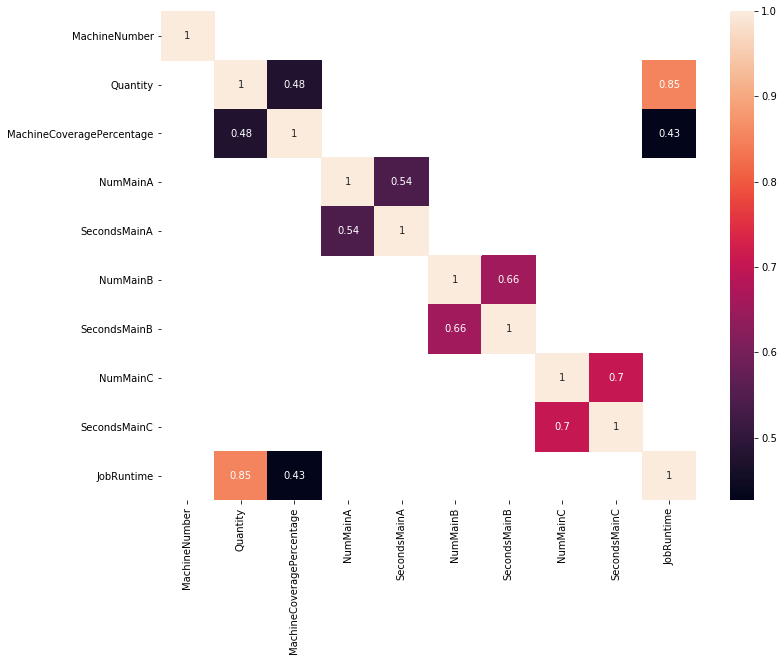

In [10]:
fig, ax = plt.subplots(figsize=(12, 9))
display(sns.heatmap(correlation[(correlation >= 0.4) | (correlation <= -0.4)],annot=True))

**JobRuntime** (which is the target variable), is highly correlated with **Quantity**. If we assume that **Quantity** relates to the number of units being produced for each 'Job', then it makes sense that increasing the **Quantity** of a job would also increase the time it takes to complete (**JobRuntime**). **JobRuntime** also has a slight correlation with **MachineCoveragePercentage** (which may be the percentage of machines in use), which suggests a longer **JobRuntime** generally means more machines are in use (although the correlation isn't paticularly high). 

The heatmap also shows a clear relationship between the '**NumMain**' and '**SecondsMain**' variables, with there being a correlation between the A, B and C pairs (for example, **NumMainC** has a high coefficient with **SecondsMainC**). It is likely that A, B, and C refer to different machines (or parts of machines), which would explain the correlations between each pair. This relationship needs to be considered when selecting features for a predictive model, as strong correlation between features can affect performance.

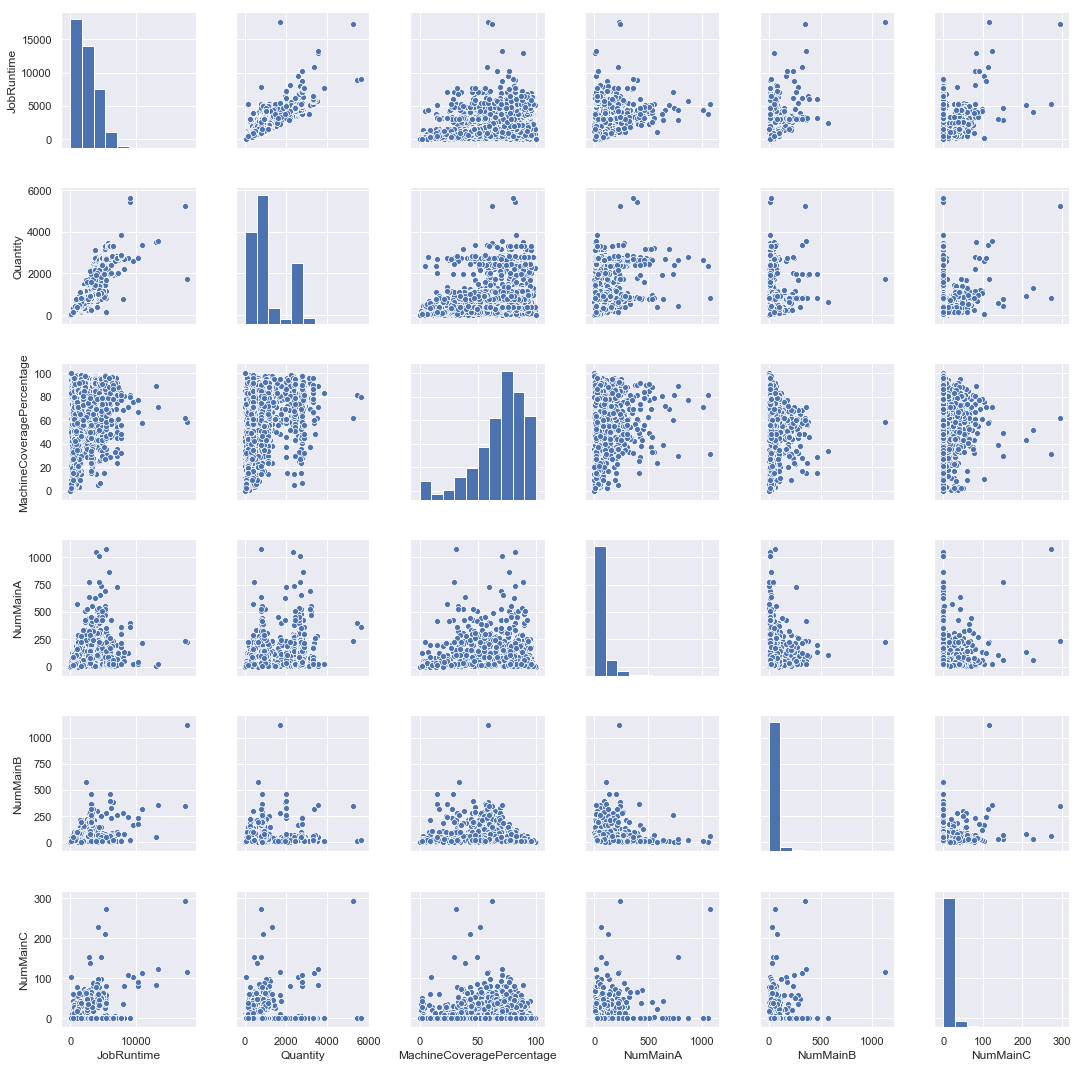

In [11]:
# Further inspection of variable relationships and distribution of each variable.

sns.set()
cols = ['JobRuntime', 'Quantity', 'MachineCoveragePercentage', 'NumMainA', 'NumMainB','NumMainC']
sns.pairplot(data[cols], height = 2.5)
plt.show()

These plots seem to agree with the conclusions drawn from the correlation heatmaps, with the **JobRuntime** v **Quantity** plots standing out as being the only ones with a high correlation. Interestingly, all three of the '**NumMain**' plots appear to show a large number of values at 0.  

The two plots below again demonstrate that **Quantity** could have high predictive power for **JobRuntime**, with **MachineCoveragePercentage** (the second highest correlated variable with **JobRuntime**) showing a much weaker relationship to the target variable.

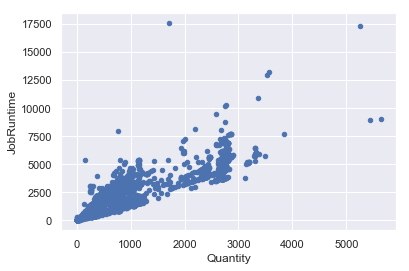

In [12]:
var = 'Quantity'
graph = pd.concat([data['JobRuntime'], data[var]], axis=1)
graph.plot.scatter(x=var, y='JobRuntime')

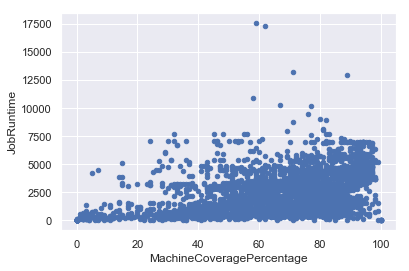

In [13]:
var = 'MachineCoveragePercentage'
graph = pd.concat([data['JobRuntime'], data[var]], axis=1)
graph.plot.scatter(x=var, y='JobRuntime')


### Categorical variables

Looking at the number of unique values for each column (shown previously), the only possible candidate for a categorical variable with any relationship to **JobRuntime** is **MachineNumber**.

However, the plot below shows no clear relationship between the variables, suggesting that the **MachineNumber** does not have a significant impact the **JobRuntime**.

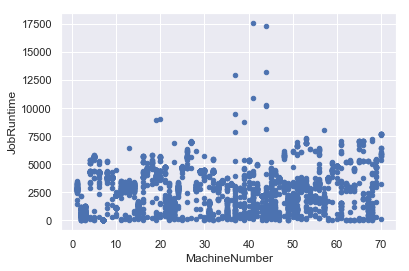

In [14]:
var = 'MachineNumber'
graph = pd.concat([data['JobRuntime'], data[var]], axis=1)
graph.plot.scatter(x=var, y='JobRuntime')


### Relationship Over Time

In [15]:
trend = data.set_index(['JobStartDate'])

trend.head()

,MachineNumber,JobID,ProductID,Quantity,MachineCoveragePercentage,NumMainA,SecondsMainA,NumMainB,SecondsMainB,NumMainC,SecondsMainC,JobRuntime
JobStartDate,,,,,,,,,,,,
2018-07-19 14:41:00,13,JX000001,PX000001,574,79,48,305,37,258,0,0,2243
2018-07-20 01:00:00,26,JX000002,PX000002,772,72,9,7,3,343,0,0,1597
2018-07-19 06:23:00,1,JX000003,PX000003,766,93,16,68,16,122,0,0,3115
2018-07-21 04:14:00,12,JX000004,PX000003,146,82,17,57,6,47,0,0,480
2018-07-20 11:44:00,44,JX000005,PX000004,163,41,73,376,90,475,21,45,640


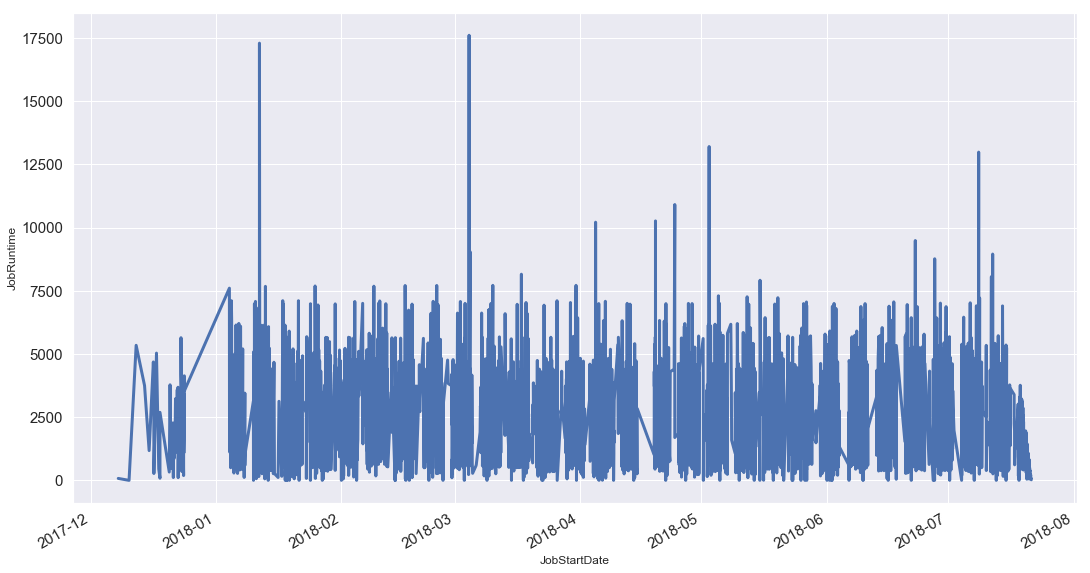

In [16]:
ax = trend['JobRuntime'].plot(figsize=(18, 10),fontsize=15, linewidth=3)
plt.ylabel('JobRuntime')
plt.show()

This plot shows no real upward or downward trend of **JobRuntime** over time. However, there do appear to be drops at regular intervals, possibly due to production being stopped on certain days (e.g. at weekends). 

## Predictive Modelling

### Feature Selection

Using the analysis above as a guide, **Quantity** and **MachineCoveragePercentage** are good candidates for features to be used in a predictive model. 

As mentioned previously, the correlation between 'A', 'B' and 'C' variables is not particularly desirable in a regression based model, therefore all three of the 'SecondsMain' variables will be dropped. This choice was made based on the fact that each of the 'NumMain' variables have a slightly higher correlation with JobRuntime than the respective 'SecondsMain' variable.

MachineNumber, JobStartDate, JobID and ProductID will also be dropped, leaving the following features:

**Quantity**

**MachineCoveragePercentage**

**NumMainA**

**NumMainB**

**NumMainC**

### Model Selection

As this is a regression problem, I will first fit a standard Linear Regression model to the data, once with regularisation (using Lasso), and once without. The use of regularisation here is to avoid the model overfitting the data.

I will also attempt using a Random Forest Regressor and XGBoost for comparison.

### Setting up training and test data

In [17]:
from sklearn.model_selection import train_test_split

# Create feature and target arrays
X = data.drop(['JobStartDate', 'MachineNumber','JobID','ProductID','JobRuntime','SecondsMainA','SecondsMainB','SecondsMainC'], axis=1)
y = data['JobRuntime']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11)

In [18]:
# write a function to fit each model to the data and measure performance

from sklearn import metrics
import numpy as np

# create dictionary to store r^2 values for comparison
r2_comparison = {}

def fit_model(algorithm, title):
    
    # fit model
    model = algorithm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # measuring model performance
    print('{0} Model Performance & Feature Coefficients'.format(title))
    performance = pd.DataFrame(columns=['Value'], index=['MAE','MSE','RMSE','R^2'])
    performance.loc['MAE'] = pd.Series({'Value':metrics.mean_absolute_error(y_test, y_pred)})
    performance.loc['MSE'] = pd.Series({'Value':metrics.mean_squared_error(y_test, y_pred)})
    performance.loc['RMSE'] = pd.Series({'Value':np.sqrt(metrics.mean_squared_error(y_test, y_pred))})
    performance.loc['R^2'] = pd.Series({'Value':metrics.r2_score(y_test,y_pred)})
    display(performance)
    
    # calculating feature coefficients
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    try:
        cdf = pd.DataFrame(data = model.coef_,index = X_train.columns, columns = ['Feature Coefficients'])
    except:
        cdf = pd.DataFrame(data = model.feature_importances_,index = X_train.columns, columns = ['Feature Coefficients'])
    cdf_sort = cdf.sort_values(by = 'Feature Coefficients', ascending = False)
    display(cdf_sort)
    
    # save r^2 value for later comparison
    r2_comparison[title] = metrics.r2_score(y_test,y_pred)

### First Model: Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

fit_model(LinearRegression(), 'Linear Regression')

Linear Regression Model Performance & Feature Coefficients


,Value
MAE,510.383
MSE,413295
RMSE,642.88
R^2,0.86231


,Feature Coefficients
NumMainC,19.81
NumMainB,9.32
MachineCoveragePercentage,7.03
Quantity,1.62
NumMainA,1.37


### Second Model: Linear Regression with Lasso regularisation

In [20]:
from sklearn.linear_model import LassoCV

fit_model(LassoCV(), 'Linear Regression (with Lasso Regularisation)')

Linear Regression (with Lasso Regularisation) Model Performance & Feature Coefficients


,Value
MAE,521.12
MSE,424134.94
RMSE,651.26
R^2,0.86


,Feature Coefficients
NumMainC,14.20
NumMainB,8.87
MachineCoveragePercentage,2.96
Quantity,1.66
NumMainA,1.25


### Third Model: Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

fit_model(RandomForestRegressor(n_estimators = 100, random_state = 11), 'Random Forest')

Random Forest Model Performance & Feature Coefficients


,Value
MAE,261.67
MSE,176186.93
RMSE,419.75
R^2,0.94


,Feature Coefficients
Quantity,0.81
NumMainC,0.07
NumMainB,0.07
NumMainA,0.03
MachineCoveragePercentage,0.02


### Fourth Model: XGBoost

In [23]:
import xgboost as xgb

fit_model(xgb.XGBRegressor(n_estimators=100),'XGBoost')

XGBoost Model Performance & Feature Coefficients


,Value
MAE,322.60
MSE,220411.70
RMSE,469.48
R^2,0.93


,Feature Coefficients
Quantity,0.36
NumMainB,0.19
MachineCoveragePercentage,0.16
NumMainC,0.16
NumMainA,0.13


### Comparing Models

In [24]:
comparison_df = pd.DataFrame.from_dict(r2_comparison, orient='index')
comparison_df.columns = ['R^2']
comparison_df.sort_values(by=['R^2'],inplace=True,ascending=False)
display(comparison_df)

,R^2
Random Forest,0.94
XGBoost,0.93
Linear Regression,0.86
Linear Regression (with Lasso Regularisation),0.86


Using R-squared as a measure for performance, the Random Forest Regressor was the most successful model. As expected, this model gave the most importance (by a long way) to the **Quantity** feature. XGBoost takes a similar approach, although there is a more even spread of importance across the features, relying less heavily on **Quantity**. Both of the linear regession models had **Quantity** with one of the smaller coefficients, and performed worse across all of the performance metrics used. 

### How good is the Random Forest model for this data?

By plotting the residuals (below), there is no clear pattern (they appear random), indicating that the model is a good fit for the data. This can be seen more clearly in the second plot, which has been 'zoomed in' to ignore outliers. 

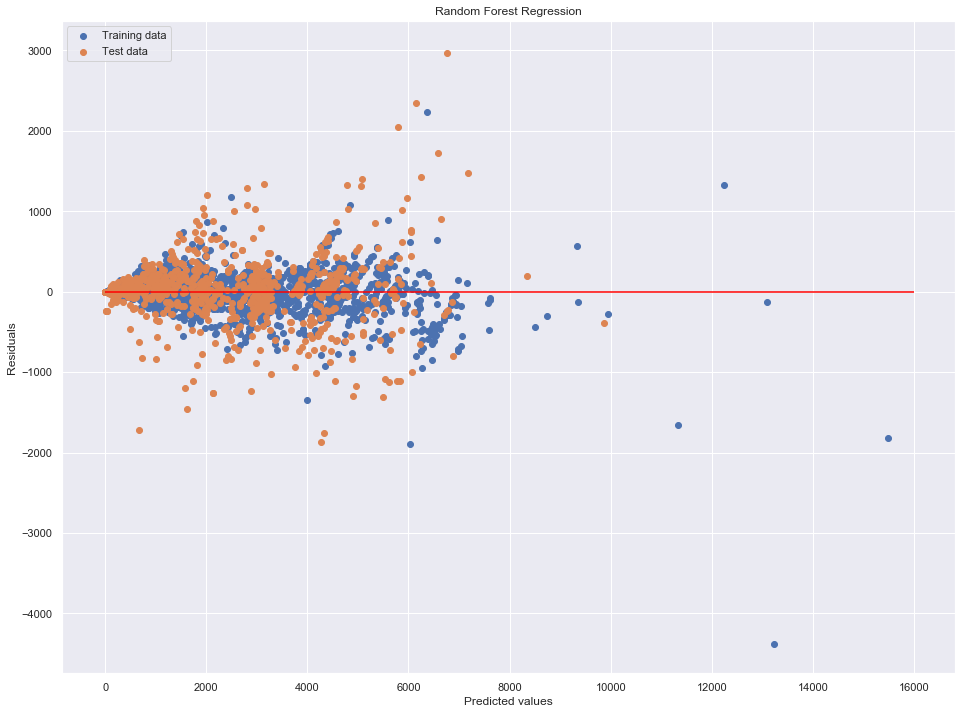

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

forest = RandomForestRegressor(n_estimators = 100, random_state = 11) 
forest.fit(X_train, y_train)
y_train_forest = forest.predict(X_train)
y_test_forest = forest.predict(X_test)

# Plotting  residuals

plt.scatter(y_train_forest, y_train_forest - y_train, label = "Training data")
plt.scatter(y_test_forest, y_test_forest - y_test, label = "Test data")
plt.title("Random Forest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 16000, color = "red")
plt.show()

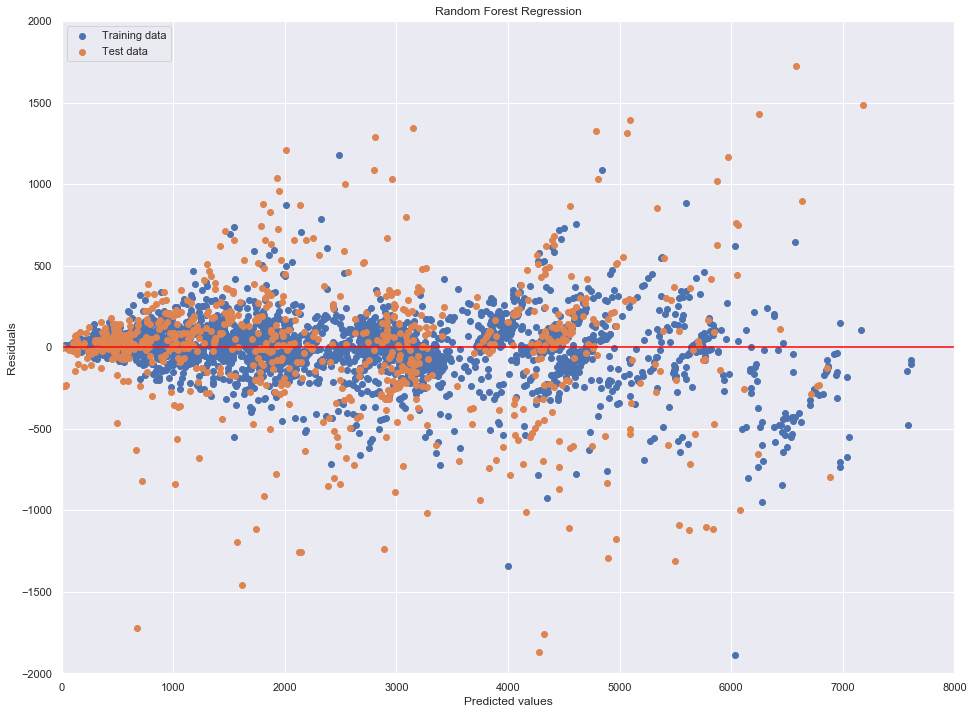

In [26]:
# Plot residuals, igoring outliers

plt.scatter(y_train_forest, y_train_forest - y_train, label = "Training data")
plt.scatter(y_test_forest, y_test_forest - y_test, label = "Test data")
plt.title("Random Forest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.xlim(0,8000)
plt.ylim(-2000,2000)
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 16000, color = "red")
plt.show()

### Visualising the model

The two plots below show the model 'in action', and are a good way of representing visually what the model is doing. 

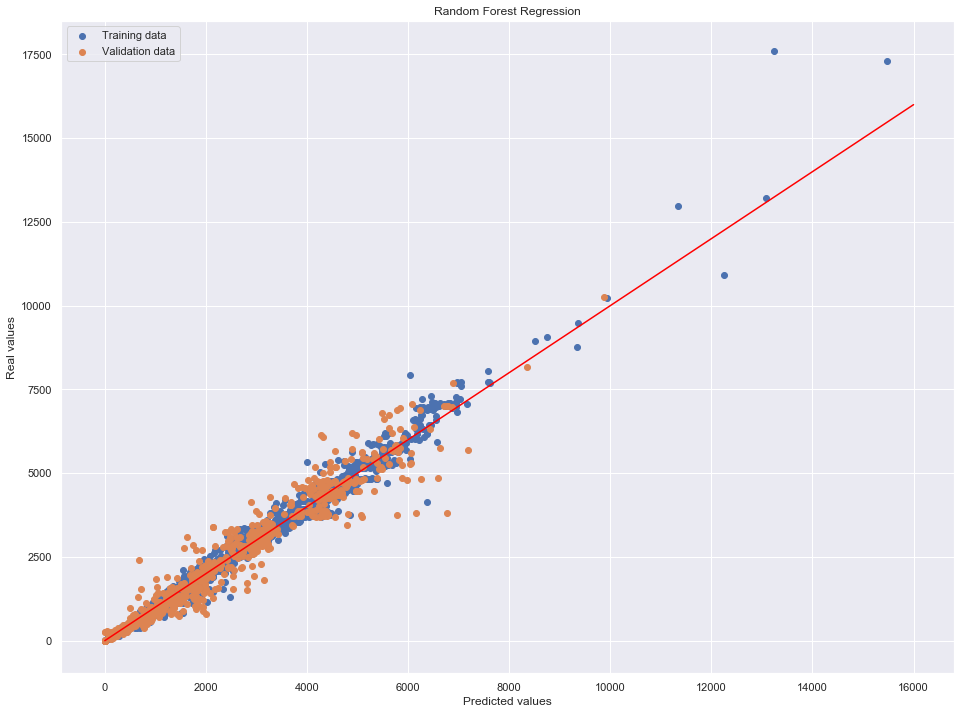

In [27]:
# Plot predictions
plt.scatter(y_train_forest, y_train, label = "Training data")
plt.scatter(y_test_forest, y_test, label = "Validation data")
plt.title("Random Forest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 16000], [0, 16000], c = "red")
plt.show()

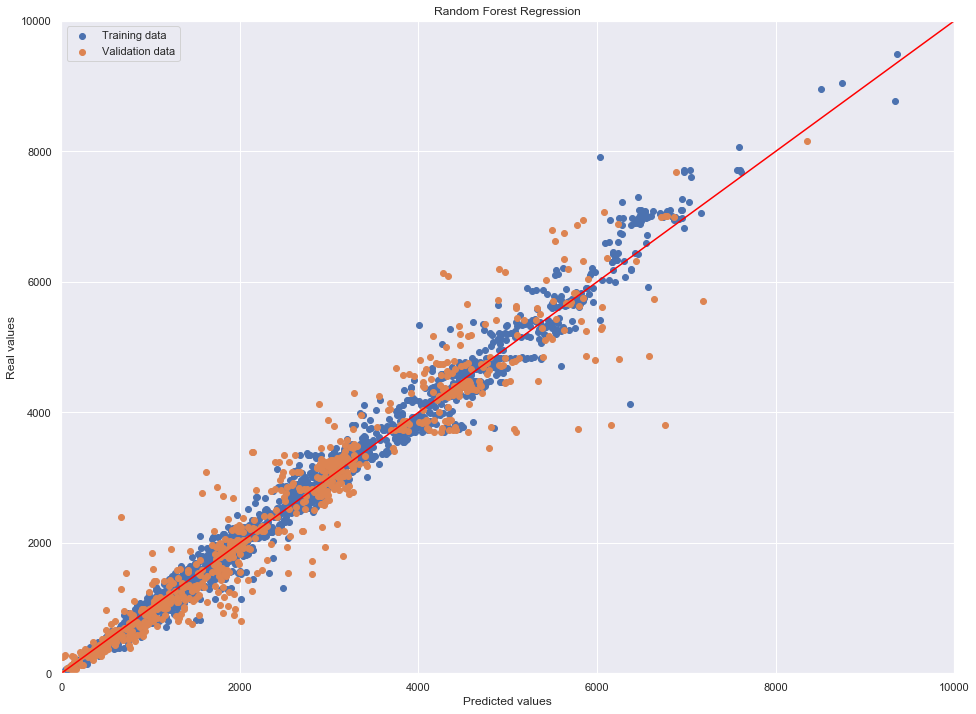

In [28]:
# Plot predictions, 'zoomed in', ignoring outliers

plt.scatter(y_train_forest, y_train, label = "Training data")
plt.scatter(y_test_forest, y_test, label = "Validation data")
plt.title("Random Forest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.legend(loc = "upper left")
plt.plot([0, 16000], [0, 16000], c = "red")
plt.show()

## Conclusion

For this data, a Random Forest Regressor (an ensemble technique) was the highest performing model, with an *R-squared* value of 0.941. The XGBoost model (which uses gradient boosting) also performed very well, with an *R-squared* value of 0.927. The **Quantity** feature was given the most importance in both cases, and each of these models could also be improved upon through parameter tuning. From these results it can be concluded that either of these two approaches could be considered for application on the factory's data, and would have a high chance of success in predicting the **JobRuntime** of jobs in the future. 